In [161]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]
# FT_Device = params["FT_NICK"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])
phi_Fl1_full = scq.identity_wrap(Fl1.phi_operator(), Fl1, [Fl1, Tr])


def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

In [162]:
dressed_epairs = get_dressed_epairs(evals, ekets) # Get dressed eigenpairs
eta = (np.abs(n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]) /
             n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))) # Get selective darkening coefficient

t_r = 5 # Rise time
t_g = 50 # Gate time

U_ideal = 0 # Identity operator in the computational subspace
U_ideal += dressed_epairs[0, 0][1] * dressed_epairs[0, 0][1].dag()
U_ideal += dressed_epairs[0, 1][1] * dressed_epairs[0, 1][1].dag()
U_ideal += dressed_epairs[1, 1][1] * dressed_epairs[1, 0][1].dag()
U_ideal += dressed_epairs[1, 0][1] * dressed_epairs[1, 1][1].dag()

def U_full2comp(U_f):
    U4x4 = 1j*np.zeros([4,4])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    U4x4[2*dx+jx,2*kx+lx] = U_f.matrix_element(dressed_epairs[dx,jx][1],dressed_epairs[kx,lx][1])
    return qt.Qobj(U4x4)

idcomp = qt.Qobj(cnot().full())

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct

def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d*t) * envelop_function(t,args['t_g'], args['t_r'])

In [140]:
result.fun
optalpha, opteta, optdetuning = result.x
result.fun, optalpha, opteta, optdetuning

(np.float64(-0.3999999999999999),
 np.float64(2.0),
 np.float64(-41.90132389032052),
 np.float64(0.9999))

In [141]:
def evolution_psi_microwave(H_tot, psi0, t_points, args):
    result = qt.sesolve(H_tot, psi0, t_points, args=args, options=qt.Options(nsteps=25000))
    return result.states

def evolution_subspace(H_tot, args, subspace_states, t_points):
    psi_t = []
    for ind, psi_0 in enumerate(subspace_states):
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args)
        psi_t.append(temp)

    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

def gate(H_tot, args):
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1], dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list)
    U_act = U_t[-1]
    return U_act

def abs_fidelity_CX1(params, t_g, t_r):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))

    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity




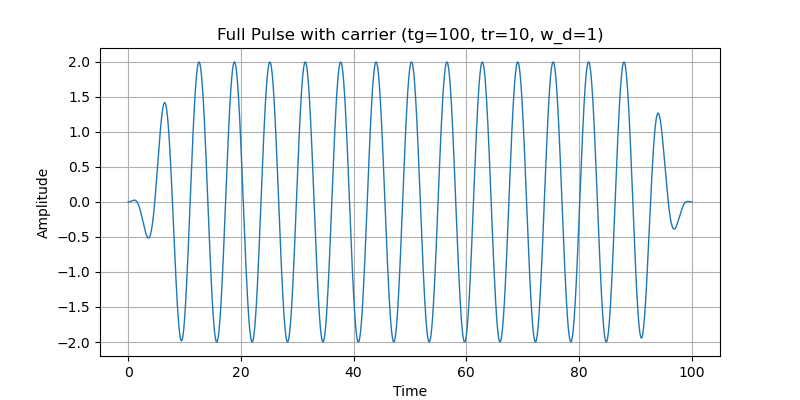

In [142]:
def plot_pulse(tg=50, t_r=5, w_d=10, num_points=5000):
    t_vals = np.linspace(0, tg, num_points)
    args = {'t_g': tg, 't_r': t_r, 'w_d': w_d}
    f_vals = [time_dep(t, args) for t in t_vals]

    plt.figure(figsize=(8,4))
    plt.plot(t_vals, f_vals, lw=1)
    plt.title(f"Full Pulse with carrier (tg={tg}, tr={t_r}, w_d={w_d})")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# Example usage: plot the full time-dependent drive
plot_pulse(tg=100, t_r=10, w_d=1)


In [51]:
eta

np.float64(0.005517442870389996)

In [163]:
t_g = 50
t_r = 5
t_list = np.linspace(0, t_g, 1000)
initial_guess = [1, eta, 0.9999]
result = opt.minimize(abs_fidelity_CX1, initial_guess, args=(t_g, t_r), method='Nelder-Mead', options={'fatol': 0.000001, 'xatol': 0.00001})
optalpha, opteta, optdetuning = result.x
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (n_Fl1_full + opteta * n_Tr_full), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)

print(dark, flip, leak,  max_fidelity)
print(result.x)

0.001005529219374335 0.0003622061861616732 0.001677075350374091 0.998297434118183
[1.77413663 0.0039626  1.00009275]


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/qutip/solver/options.py: 16

tg= 50 ns, tr= 5 ns, alpha=0.5 | Max Fidelity=0.998298 | Time=57.54 s
tg= 50 ns, tr= 5 ns, alpha=1.0 | Max Fidelity=0.998297 | Time=52.97 s
tg= 50 ns, tr= 5 ns, alpha=2.0 | Max Fidelity=0.998298 | Time=50.77 s
tg= 50 ns, tr= 8 ns, alpha=0.5 | Max Fidelity=0.999955 | Time=45.79 s
tg= 50 ns, tr= 8 ns, alpha=1.0 | Max Fidelity=0.999955 | Time=55.34 s
tg= 50 ns, tr= 8 ns, alpha=2.0 | Max Fidelity=0.999955 | Time=49.43 s
tg= 50 ns, tr=10 ns, alpha=0.5 | Max Fidelity=0.999982 | Time=54.85 s
tg= 50 ns, tr=10 ns, alpha=1.0 | Max Fidelity=0.999982 | Time=62.56 s
tg= 50 ns, tr=10 ns, alpha=2.0 | Max Fidelity=0.999982 | Time=54.63 s
tg=100 ns, tr= 5 ns, alpha=0.5 | Max Fidelity=0.999798 | Time=75.75 s
tg=100 ns, tr= 5 ns, alpha=1.0 | Max Fidelity=0.999798 | Time=100.23 s
tg=100 ns, tr= 5 ns, alpha=2.0 | Max Fidelity=0.926947 | Time=114.68 s
tg=100 ns, tr= 8 ns, alpha=0.5 | Max Fidelity=0.999884 | Time=84.31 s
tg=100 ns, tr= 8 ns, alpha=1.0 | Max Fidelity=0.999884 | Time=97.70 s
tg=100 ns, tr= 8 n

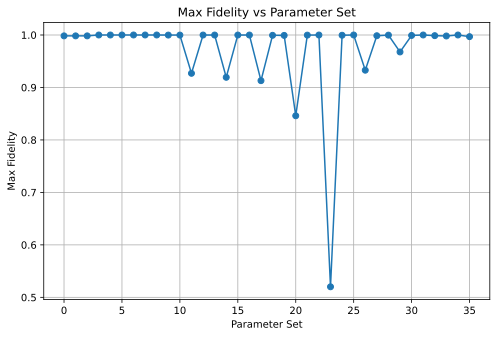

In [43]:
import time

t_g_list = [50, 100, 150, 200]
t_r_list = [5, 8, 10]
alpha_list = [0.5, 1, 2]

max_fidelity_list = []
results_list = []

# Make abs_fidelity_CX1 accept tr explicitly
# def abs_fidelity_CX1(params, t_g, t_r):  # <-- update your function signature
#     alpha, eta, detuning = params
#     w_d = (dressed_epairs[1,1][0] - dressed_epairs[1,0][0]) * detuning
#     H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
#     # IMPORTANT: pass the scalar t_r into args
#     args = {'t_g': t_g, 'w_d': w_d, 't_r': t_r}
#     ...
#     return -fidelity

for tg in t_g_list:
    # refresh the time grid used by your evolution for this gate length
    t_list = np.linspace(0, tg, 1000)

    for tr in t_r_list:
        for alpha in alpha_list:
            start = time.time()

            initial_guess = [alpha, eta, 0.9999]
            # pass BOTH tg and tr as scalar args to the objective
            result = opt.minimize(
                abs_fidelity_CX1,
                initial_guess,
                args=(tg, tr),                      # <-- key change
                method='Nelder-Mead',
                options={'fatol': 1e-5, 'xatol': 1e-5}
            )

            elapsed = time.time() - start
            max_fidelity = -result.fun

            max_fidelity_list.append(max_fidelity)
            results_list.append(result)

            print(f"tg={tg:3d} ns, tr={tr:2d} ns, alpha={alpha:3.1f} | "
                  f"Max Fidelity={max_fidelity:.6f} | Time={elapsed:.2f} s")

plt.figure(figsize=(8,5))
plt.plot(max_fidelity_list, 'o-')
plt.xlabel('Parameter Set')
plt.ylabel('Max Fidelity')
plt.title('Max Fidelity vs Parameter Set')
plt.grid(True)
plt.show()


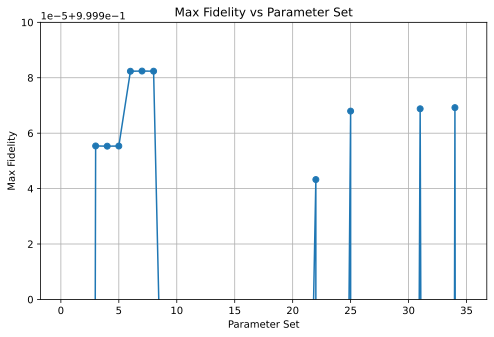

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(max_fidelity_list, 'o-')
plt.xlabel('Parameter Set')
plt.ylabel('Max Fidelity')
plt.title('Max Fidelity vs Parameter Set')
plt.grid(True)
plt.ylim(.9999, 1)
plt.show()



Considering crosstalk from Fluxonium charge line

\begin{align}
\Omega_{00 \to 01} 
&= A_F \Big( \mathcal{E}_F n_{F,00 \to 01} 
   + {\color{red}{\mathcal{E}_{FT} n_{T,00 \to 01}}}  
   + \eta'  \mathcal{E}_T n_{T,00 \to 01}\Big) = 0  \\[6pt]
\eta 
&= - \frac{\mathcal{E}_F n_{F,00 \to 01} + \mathcal{E}_{FT} n_{T,00 \to 01}}
        {\mathcal{E}_T n_{T,00 \to 01}} \\[6pt]
&= - \left( \frac{\mathcal{E}_F}{\mathcal{E}_T} 
             \frac{n_{F,00 \to 01}}{n_{T,00 \to 01}}
           + \frac{\mathcal{E}_{FT}}{\mathcal{E}_T} \right)
\end{align}


In [164]:
def eta(EF, EFT, ET, nF, nT):
    """
    Compute eta from the drive cancellation equation:
    
        eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    
    Parameters
    ----------
    EF : float
        Direct drive amplitude (mathcal{E}_F)
    EFT : float
        Crosstalk drive amplitude (mathcal{E}_{FT})
    ET : float
        Target drive amplitude (mathcal{E}_T)
    nF : float
        Matrix element n_{F,00->01}
    nT : float
        Matrix element n_{T,00->01}
    
    Returns
    -------
    float
        Value of eta
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

# Example with dummy values
nF   = abs(n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT   = abs(n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
EFT  = .011/95.5
EF   = .12/65
ET   = .163 / 95.5


eta_val = eta(EF, EFT, ET, nF, nT)
print("eta =", eta_val)



def abs_fidelity_CX1_with_crosstalk(params, t_g, t_r, EF, EFT, ET): 
    
    alpha, eta_p, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full +(EFT + ET * eta_p) * n_Tr_full), time_dep]]
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))
    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity


eta = -0.07345256208538643


In [167]:
nF   = abs(n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT   = abs(n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
EFT  = .011/95.5
EF   = .12/65
ET   = .163 / 95.5

eta_p = eta(EF, EFT, ET, nF, nT)
alpha = 700
detuning = 0.9999
t_g = 200
t_r = 5

initial_guess = [alpha, eta_p, detuning]


result = opt.minimize(abs_fidelity_CX1_with_crosstalk, initial_guess, args=(t_g, t_r, EF, EFT, ET), method='Nelder-Mead', options={'fatol': 0.000001, 'xatol': 0.00001})

optalpha, opteta_p, optdetuning = result.x
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)

print(dark, flip, leak,  max_fidelity)
print(result.x)

0.0063458304907239695 0.03418779195028878 0.04427452732538728 0.9511249016402192
[ 7.48497860e+02 -6.14606707e-02  1.00010851e+00]


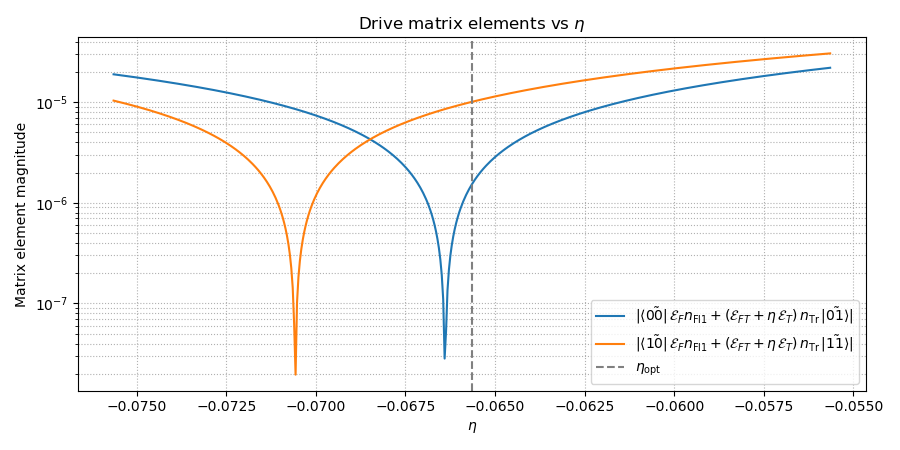

In [157]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(opteta_p - .01, opteta_p + .01, 501)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(opteta_p, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


 /var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_51251/775351461.py: 12

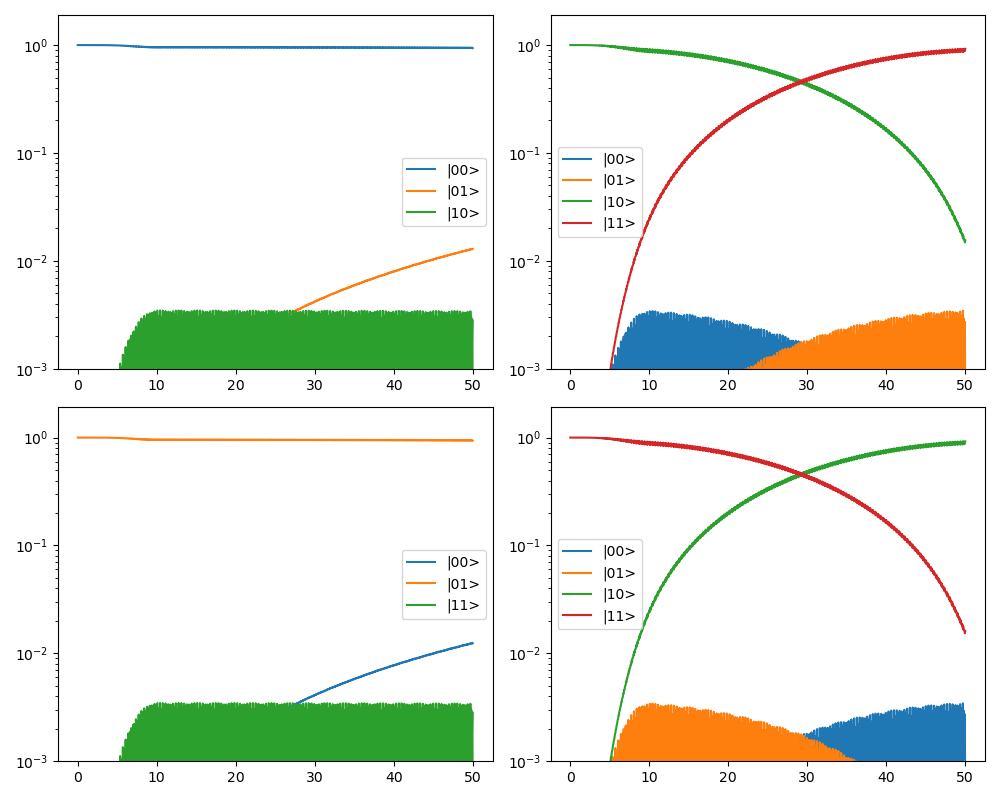

In [158]:
def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-4 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                axs[i].semilogy(t_list, p_list, label=label)

        axs[i].set_ylim(1e-3, 1.9)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

In [107]:
import time

t_g_list = [50, 100, 150, 200]
t_r_list = [5, 8, 10]
alpha_list = [0.5, 1, 2]

max_fidelity_list = []
results_list = []
error_list = []

# Make abs_fidelity_CX1 accept tr explicitly
# def abs_fidelity_CX1(params, t_g, t_r):  # <-- update your function signature
#     alpha, eta, detuning = params
#     w_d = (dressed_epairs[1,1][0] - dressed_epairs[1,0][0]) * detuning
#     H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
#     # IMPORTANT: pass the scalar t_r into args
#     args = {'t_g': t_g, 'w_d': w_d, 't_r': t_r}
#     ...
#     return -fidelity

for tg in t_g_list:
    # refresh the time grid used by your evolution for this gate length
    t_list = np.linspace(0, tg, 1000)

    for tr in t_r_list:
        for alpha in alpha_list:
            start = time.time()

            initial_guess = [alpha, eta_p, 0.9999]
            # pass BOTH tg and tr as scalar args to the objective
            result = opt.minimize(
                abs_fidelity_CX1_with_crosstalk,
                initial_guess,
                args=(t_g, t_r, EF, EFT, ET),                      # <-- key change
                method='Nelder-Mead',
                options={'fatol': 1e-5, 'xatol': 1e-6}
            )

            elapsed = time.time() - start
            max_fidelity = -result.fun

            optalpha, opteta_p, optdetuning = result.x
            max_fidelity_list.append(max_fidelity)
            results_list.append(result)
            U_act = np.abs(U_full2comp(gate(H_tot, args)).full())
            a = 1 - U_act[0,0]
            b = 1 - U_act[1,1]
            c = 1 - U_act[2,3]
            d = 1 - U_act[3,2]

            dark = 2*(a + b)/5
            flip = 2*(c + d)/5

            leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)

            error_list.append((dark, flip, leak))   

            print(f"tg={tg:3d} ns, tr={tr:2d} ns, alpha={alpha:3.1f},{optalpha:3.1f}, eta_p={opteta_p:3.1f}, dark={dark:.6f}, flip={flip:.6f}, leak={leak:.6f} | "
                  f"Max Fidelity={max_fidelity:.6f} | Time={elapsed:.2f} s")

plt.figure(figsize=(8,5))
plt.plot(max_fidelity_list, 'o-')
plt.xlabel('Parameter Set')
plt.ylabel('Max Fidelity')
plt.title('Max Fidelity vs Parameter Set')
plt.grid(True)
plt.show()


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/qutip/solver/options.py: 16

tg= 50 ns, tr= 5 ns, alpha=0.5,1.4, eta_p=-35.2, dark=0.007509, flip=0.038636, leak=0.047116 | Max Fidelity=0.945099 | Time=73.59 s
tg= 50 ns, tr= 5 ns, alpha=1.0,1.4, eta_p=-35.2, dark=0.007509, flip=0.038636, leak=0.047116 | Max Fidelity=0.945096 | Time=66.94 s
tg= 50 ns, tr= 5 ns, alpha=2.0,1.4, eta_p=-35.2, dark=0.007509, flip=0.038636, leak=0.047116 | Max Fidelity=0.945097 | Time=75.72 s
tg= 50 ns, tr= 8 ns, alpha=0.5,1.4, eta_p=-35.2, dark=0.007509, flip=0.038636, leak=0.047116 | Max Fidelity=0.945099 | Time=80.76 s
tg= 50 ns, tr= 8 ns, alpha=1.0,1.4, eta_p=-35.2, dark=0.007509, flip=0.038636, leak=0.047116 | Max Fidelity=0.945096 | Time=67.50 s
tg= 50 ns, tr= 8 ns, alpha=2.0,1.4, eta_p=-35.2, dark=0.007509, flip=0.038636, leak=0.047116 | Max Fidelity=0.945097 | Time=75.47 s
tg= 50 ns, tr=10 ns, alpha=0.5,1.4, eta_p=-35.2, dark=0.007509, flip=0.038636, leak=0.047116 | Max Fidelity=0.945099 | Time=74.23 s
tg= 50 ns, tr=10 ns, alpha=1.0,1.4, eta_p=-35.2, dark=0.007509, flip=0.03863

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

tg=100 ns, tr= 5 ns, alpha=0.7,0.7, eta_p=-35.6, dark=0.014766, flip=0.644629, leak=0.000015 | Max Fidelity=0.999890 | Time=184.03 s


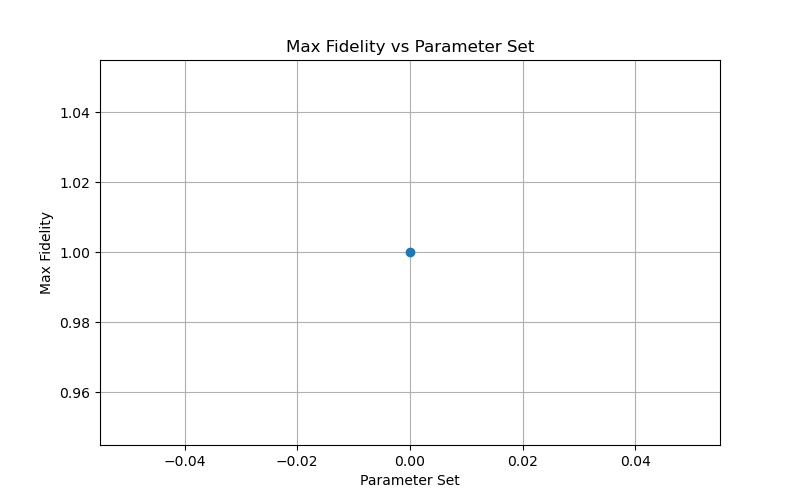

In [ ]:
import time

t_g_list = [100]
t_r_list = [5]
alpha_list = [0.7]

max_fidelity_list = []
results_list = []
error_list = []


for tg in t_g_list:
    # refresh the time grid used by your evolution for this gate length
    t_list = np.linspace(0, tg, 1000)

    for tr in t_r_list:
        for alpha in alpha_list:
            start = time.time()

            initial_guess = [alpha, eta_p, 0.9999]
            # pass BOTH tg and tr as scalar args to the objective
            result = opt.minimize(
                abs_fidelity_CX1_with_crosstalk,
                initial_guess,
                args=(t_g, t_r, EF, EFT, ET),                      # <-- key change
                method='Nelder-Mead',
                options={'fatol': 1e-8, 'xatol': 1e-8}
            )

            elapsed = time.time() - start
            max_fidelity = -result.fun

            optalpha, opteta_p, optdetuning = result.x
            max_fidelity_list.append(max_fidelity)
            results_list.append(result)
            
            U_act = np.abs(U_full2comp(gate(H_tot, args)).full())
            a = 1 - U_act[0,0]
            b = 1 - U_act[1,1]
            c = 1 - U_act[2,3]
            d = 1 - U_act[3,2]

            dark = 2*(a + b)/5
            flip = 2*(c + d)/5

            leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)

            error_list.append((dark, flip, leak))   

            print(f"tg={tg:3d} ns, tr={tr:2d} ns, alpha={alpha:3.3f},{optalpha:3.3f}, eta_p={opteta_p:3.3f}, dark={dark:.6f}, flip={flip:.6f}, leak={leak:.6f} | "
                  f"Max Fidelity={max_fidelity:.6f} | Time={elapsed:.2f} s")

plt.figure(figsize=(8,5))
plt.plot(max_fidelity_list, 'o-')
plt.xlabel('Parameter Set')
plt.ylabel('Max Fidelity')
plt.title('Max Fidelity vs Parameter Set')
plt.grid(True)
plt.show()


In [118]:
optalpha, opteta_p, optdetuning 
eta_p

-41.90132389032052

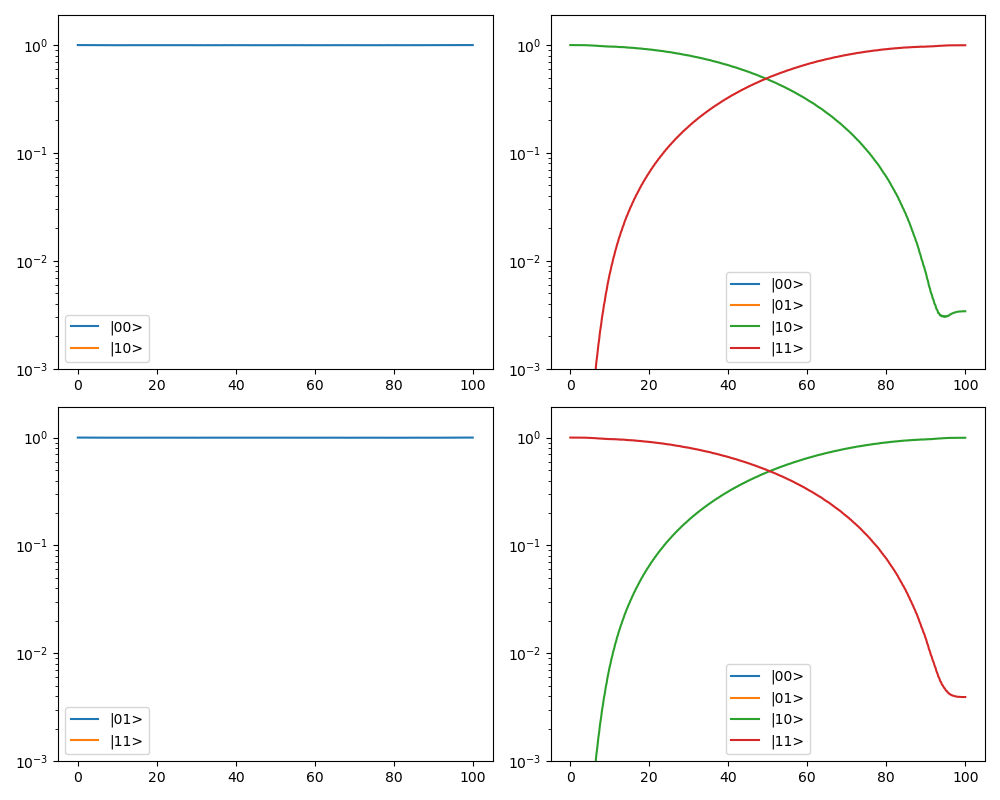

In [117]:

H_tot = [H_full, [optalpha * (EF * n_Fl1_full +(EFT + ET * opteta_p) * n_Tr_full), time_dep]]

def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-5 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                axs[i].semilogy(t_list, p_list, label=label)

        axs[i].set_ylim(1e-3, 1.9)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

#Adding decoherence

In [125]:
# --- Choose transition times (ns). Put your device numbers here.
T1_F_01, Tphi_F_01 = 200e3, 93e3   # Fluxonium 0-1
T1_F_12, Tphi_F_12 =  10e3,  10e3   # Fluxonium 1-2
T1_T_01, Tphi_T_01 = 40e3, 50e3   # Transmon 0-1
T1_T_12, Tphi_T_12 =  20e3,  20e3   # Transmon 1-2

# Rates
g1_F_01, gphi_F_01 = 1/T1_F_01, 1/Tphi_F_01
g1_F_12, gphi_F_12 = 1/T1_F_12, 1/Tphi_F_12
g1_T_01, gphi_T_01 = 1/T1_T_01, 1/Tphi_T_01
g1_T_12, gphi_T_12 = 1/T1_T_12, 1/Tphi_T_12

# --- Local projectors on each subsystem (dim = trunc)
# projectors / ladders in the local eigenbasis (size = trunc)
P00 = lambda dim: qt.basis(dim,0) * qt.basis(dim,0).dag()
P11 = lambda dim: qt.basis(dim,1) * qt.basis(dim,1).dag()
P22 = lambda dim: qt.basis(dim,2) * qt.basis(dim,2).dag()
P01 = lambda dim: qt.basis(dim,0) * qt.basis(dim,1).dag()   # |0><1|
P12 = lambda dim: qt.basis(dim,1) * qt.basis(dim,2).dag()   # |1><2|

# --- Lift to full space, marking they are in the EIGENBASIS
L_F_01_relax = scq.identity_wrap(P01(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)
L_F_01_phi   = scq.identity_wrap(P00(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)
L_F_12_relax = scq.identity_wrap(P12(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)
L_F_12_phi   = scq.identity_wrap(P22(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)

L_T_01_relax = scq.identity_wrap(P01(trunc), Tr,  [Fl1, Tr], op_in_eigenbasis=True)
L_T_01_phi   = scq.identity_wrap(P00(trunc), Tr,  [Fl1, Tr], op_in_eigenbasis=True)
L_T_12_relax = scq.identity_wrap(P12(trunc), Tr,  [Fl1, Tr], op_in_eigenbasis=True)
L_T_12_phi   = scq.identity_wrap(P22(trunc), Tr,  [Fl1, Tr], op_in_eigenbasis=True)


# --- Collapse operators with physical rates
c_ops = [
    np.sqrt(g1_F_01)  * L_F_01_relax,
    np.sqrt(2*gphi_F_01) * L_F_01_phi,
    np.sqrt(g1_F_12)  * L_F_12_relax,
    np.sqrt(2*gphi_F_12) * L_F_12_phi,
    np.sqrt(g1_T_01)  * L_T_01_relax,
    np.sqrt(2*gphi_T_01) * L_T_01_phi,
    np.sqrt(g1_T_12)  * L_T_12_relax,
    np.sqrt(2*gphi_T_12) * L_T_12_phi,
]


In [126]:
def evolution_psi_microwave(H_tot, psi0, t_points, args, c_ops):
    result = qt.mesolve(H_tot, psi0, t_points, c_ops=c_ops,
                        args=args, options=qt.Options(nsteps=25000))
    return result.states
    
def evolution_subspace(H_tot, args, subspace_states, t_points, c_ops):
    psi_t = []
    for psi_0 in subspace_states:
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args, c_ops=c_ops)
        psi_t.append(temp)

    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t


def gate(H_tot, args, c_ops):
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1],
                  dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list, c_ops)
    return U_t[-1]

def abs_fidelity_CX1_with_crosstalk(params, t_g, t_r, EF, EFT, ET, c_ops): 
    alpha, eta_p, detuning = params
    w_d  = (dressed_epairs[1,1][0] - dressed_epairs[1,0][0]) * detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full + (EFT - ET * eta_p) * n_Tr_full), time_dep]]
    args  = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

    # build gate with Lindblad dynamics (mesolve) and project to 4x4
    U_full_tg = gate(H_tot, args, c_ops)            # 36x36 map-at-final-time
    U_act     = U_full2comp(U_full_tg)              # 4x4 complex Qobj

    # Proper average gate fidelity vs ideal CNOT (dimension d=4)
    # F_avg = (|Tr(U_ideal^† U_act)|^2 + d) / [d(d+1)]
    d = 4
    overlap = (idcomp.dag() * U_act).tr()
    fidelity = (abs(overlap)**2 + d) / (d*(d+1))

    return -float(fidelity)



In [ ]:
# time grid per gate time
t_list = np.linspace(0, t_g, 1000)

# c_ops built as above
initial_guess = [alpha, eta_p, detuning]
result = opt.minimize(
    abs_fidelity_CX1_with_crosstalk,
    initial_guess,
    args=(t_g, t_r, EF, EFT, ET, c_ops),
    method='Nelder-Mead',
    options={'fatol': 1e-5, 'xatol': 1e-5}
)


In [137]:
# Build P = sum_i |e_i><e_i| onto the 4 dressed basis states
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]
# FT_Device = params["UMA5"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])
phi_Fl1_full = scq.identity_wrap(Fl1.phi_operator(), Fl1, [Fl1, Tr])


def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

comp_kets = [dressed_epairs[0,0][1],
             dressed_epairs[0,1][1],
             dressed_epairs[1,0][1],
             dressed_epairs[1,1][1]]
P = sum([ket*ket.dag() for ket in comp_kets])  # 36x36 projector

def build_superop(H_tot, args, c_ops, t_list, comp_kets, P):
    # 16 operator basis elements E_mn = |e_m><e_n|
    E = [comp_kets[m] * comp_kets[n].dag() for m in range(4) for n in range(4)]
    cols = []
    for Emn in E:
        sol = qt.mesolve(
            H_tot, Emn, t_list, c_ops=c_ops, args=args,
            options=qt.Options(nsteps=10000, rtol=1e-6, atol=1e-8)  # Increase nsteps here
        )
        Emn_tg = sol.states[-1]           # 36x36 Qobj
        Emn_pr = P * Emn_tg * P           # project to comp subspace

        # Build 4x4 matrix with elements <ei|Emn_pr|ej>
        M4 = np.zeros((4, 4), dtype=complex)
        for i, ei in enumerate(comp_kets):
            for j, ej in enumerate(comp_kets):
                M4[i, j] = Emn_pr.matrix_element(ei, ej)

        cols.append(M4.reshape(16, order='F'))
    S = np.column_stack(cols)             # 16x16 superoperator
    return S

def super_from_unitary(U4):
    # U4 is 4x4 Qobj or ndarray (complex)
    U = U4.full() if isinstance(U4, qt.Qobj) else U4
    return np.kron(U, U.conj())  # 16x16

def avg_gate_fidelity_from_super(S_real, U_ideal_qobj):
    d = 4
    S_ideal = super_from_unitary(U_ideal_qobj)
    Fe = np.trace(S_ideal.conj().T @ S_real).real / (d*d)
    Favg = (d*Fe + 1) / (d + 1)
    return Favg


def gate_channel(H_tot, args, c_ops, t_list, comp_kets, P):
    return build_superop(H_tot, args, c_ops, t_list, comp_kets, P)  # 16x16

def obj_with_crosstalk_channel(params, t_g, t_r, EF, EFT, ET, c_ops, t_list, comp_kets, P):
    alpha, eta_p, detuning = params
    w_d  = (dressed_epairs[1,1][0] - dressed_epairs[1,0][0]) * detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full + (EFT + ET * eta_p) * n_Tr_full), time_dep]]
    args  = {'t_g': t_g, 'w_d': w_d, 't_r': t_r}

    S_real = gate_channel(H_tot, args, c_ops, t_list, comp_kets, P)  # 16x16
    Favg   = avg_gate_fidelity_from_super(S_real, idcomp)            # scalar
    return -float(Favg)

t_list = np.linspace(0, t_g, 20)
initial_guess = [alpha, eta_p, detuning]
result = opt.minimize(
    obj_with_crosstalk_channel,
    initial_guess,
    args=(t_g, t_r, EF, EFT, ET, c_ops, t_list, comp_kets, P),
    method='Nelder-Mead',
    options={'fatol': 1e-5, 'xatol': 1e-5}
)



capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 